# When pd.read_csv is not enough

# Christian Barra
# PyData Wroclaw - 13/09/2017

### Questions? Save them for later!

# Hey there!

# I am (freelancer U consultant U trainer) ∩ Python 🐍

# Looking for Python courses?
# check pybootcamp.com

## Let's start with the Taxi

In [38]:
from s3fs import S3FileSystem, S3File

s3 = S3FileSystem(anon=True)
files = s3.ls('dask-data/nyc-taxi/2015/')
size = 0
for file in files:
    try:
        info = s3.info(file)
        print(f"{file}: {info['Size']/1e9} GB")
        size += info['Size']/1e9
    except FileNotFoundError:
        pass
print(size)

dask-data/nyc-taxi/2015/yellow_tripdata_2015-01.csv: 1.985964692 GB
dask-data/nyc-taxi/2015/yellow_tripdata_2015-02.csv: 1.945357622 GB
dask-data/nyc-taxi/2015/yellow_tripdata_2015-03.csv: 2.087971794 GB
dask-data/nyc-taxi/2015/yellow_tripdata_2015-04.csv: 2.046225765 GB
dask-data/nyc-taxi/2015/yellow_tripdata_2015-05.csv: 2.061869121 GB
dask-data/nyc-taxi/2015/yellow_tripdata_2015-06.csv: 1.932049357 GB
dask-data/nyc-taxi/2015/yellow_tripdata_2015-07.csv: 1.812530041 GB
dask-data/nyc-taxi/2015/yellow_tripdata_2015-08.csv: 1.744852237 GB
dask-data/nyc-taxi/2015/yellow_tripdata_2015-09.csv: 1.76041271 GB
dask-data/nyc-taxi/2015/yellow_tripdata_2015-10.csv: 1.931460927 GB
dask-data/nyc-taxi/2015/yellow_tripdata_2015-11.csv: 1.773468989 GB
dask-data/nyc-taxi/2015/yellow_tripdata_2015-12.csv: 1.796283025 GB
22.878446280000002


In [39]:
%%bash
free -h

              total        used        free      shared  buff/cache   available
Mem:           7.6G        288M        374M        8.7M        7.0G        7.0G
Swap:            0B          0B          0B


# It's not a big dataset but won't fit inside my memory

# Let's try with Pandas

In [40]:
import pandas as pd
import numpy as np
import time

In [42]:
df = pd.read_csv("s3://dask-data/nyc-taxi/2015/yellow_tripdata_2015-01.csv", nrows=5, parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'], )

In [43]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0,0.3,16.30


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 19 columns):
VendorID                 5 non-null int64
tpep_pickup_datetime     5 non-null datetime64[ns]
tpep_dropoff_datetime    5 non-null datetime64[ns]
passenger_count          5 non-null int64
trip_distance            5 non-null float64
pickup_longitude         5 non-null float64
pickup_latitude          5 non-null float64
RateCodeID               5 non-null int64
store_and_fwd_flag       5 non-null object
dropoff_longitude        5 non-null float64
dropoff_latitude         5 non-null float64
payment_type             5 non-null int64
fare_amount              5 non-null float64
extra                    5 non-null float64
mta_tax                  5 non-null float64
tip_amount               5 non-null float64
tolls_amount             5 non-null int64
improvement_surcharge    5 non-null float64
total_amount             5 non-null float64
dtypes: datetime64[ns](2), float64(11), int64(5), object(1)


## Using chunks

In [48]:
my_data = pd.read_csv("s3://dask-data/nyc-taxi/2015/yellow_tripdata_2015-01.csv", chunksize=1000, parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"])

In [49]:
type(my_data)

pandas.io.parsers.TextFileReader

In [52]:
%%time
for month in months(to_month=2):
    data_set = f"s3://dask-data/nyc-taxi/2015/yellow_tripdata_2015-{month}.csv"
    print("\t" + data_set)
    my_data = pd.read_csv(data_set, chunksize=100000, parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"])
    for chunk, df in enumerate(my_data):
        # do something
        pass
    print(f"\t\tChunk number: {chunk}")

	s3://dask-data/nyc-taxi/2015/yellow_tripdata_2015-01.csv
		Chunk number: 128
CPU times: user 1min 23s, sys: 11.4 s, total: 1min 35s
Wall time: 6min


# It works but:
* Pandas was made to work in memory and with datasets that fit it
* Note that `clean` and it starts to be complex to work with multiple files
* Slow....6 minutes just to parse the first month

# Dask

Dask is very cool and complex library and
you can schedule tasks locally and remotely

In [53]:
from time import sleep
import random
from dask import delayed

In [54]:
def inc(x):
    sleep(1)
    return x + 1

def square(y):
    sleep(1)
    return y ** 2

def add(x, y):
    sleep(1)
    return x + y

x = delayed(inc)(10)
y = delayed(square)(5)
total = delayed(add)(square(x), y)

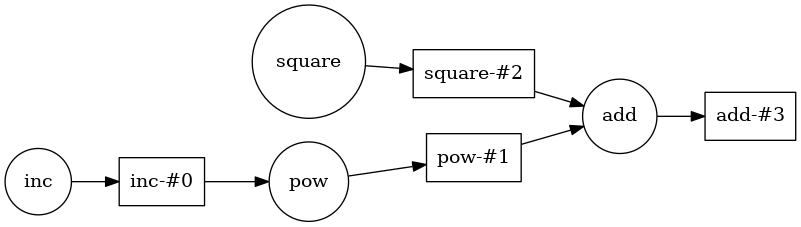

In [55]:
total.visualize(rankdir="LR")

# Graphs!

Directed Acyclic Graph

Nothing is computed until...you compute it.

In [56]:
%time total.compute()

CPU times: user 8 ms, sys: 8 ms, total: 16 ms
Wall time: 2.02 s


146

In [57]:
def inc(x):
    sleep(random.random())
    return x + 1

def double(x):
    sleep(random.random())
    return x + 2

def add(x, y):
    sleep(random.random())
    return x + y

data = [1, 2, 3, 4, 5, 6, 7, 8]

output = []
for x in data:
    a = delayed(inc)(x)
    b = delayed(double)(x)
    c = delayed(add)(a, b)
    output.append(c)

total = delayed(sum)(output)

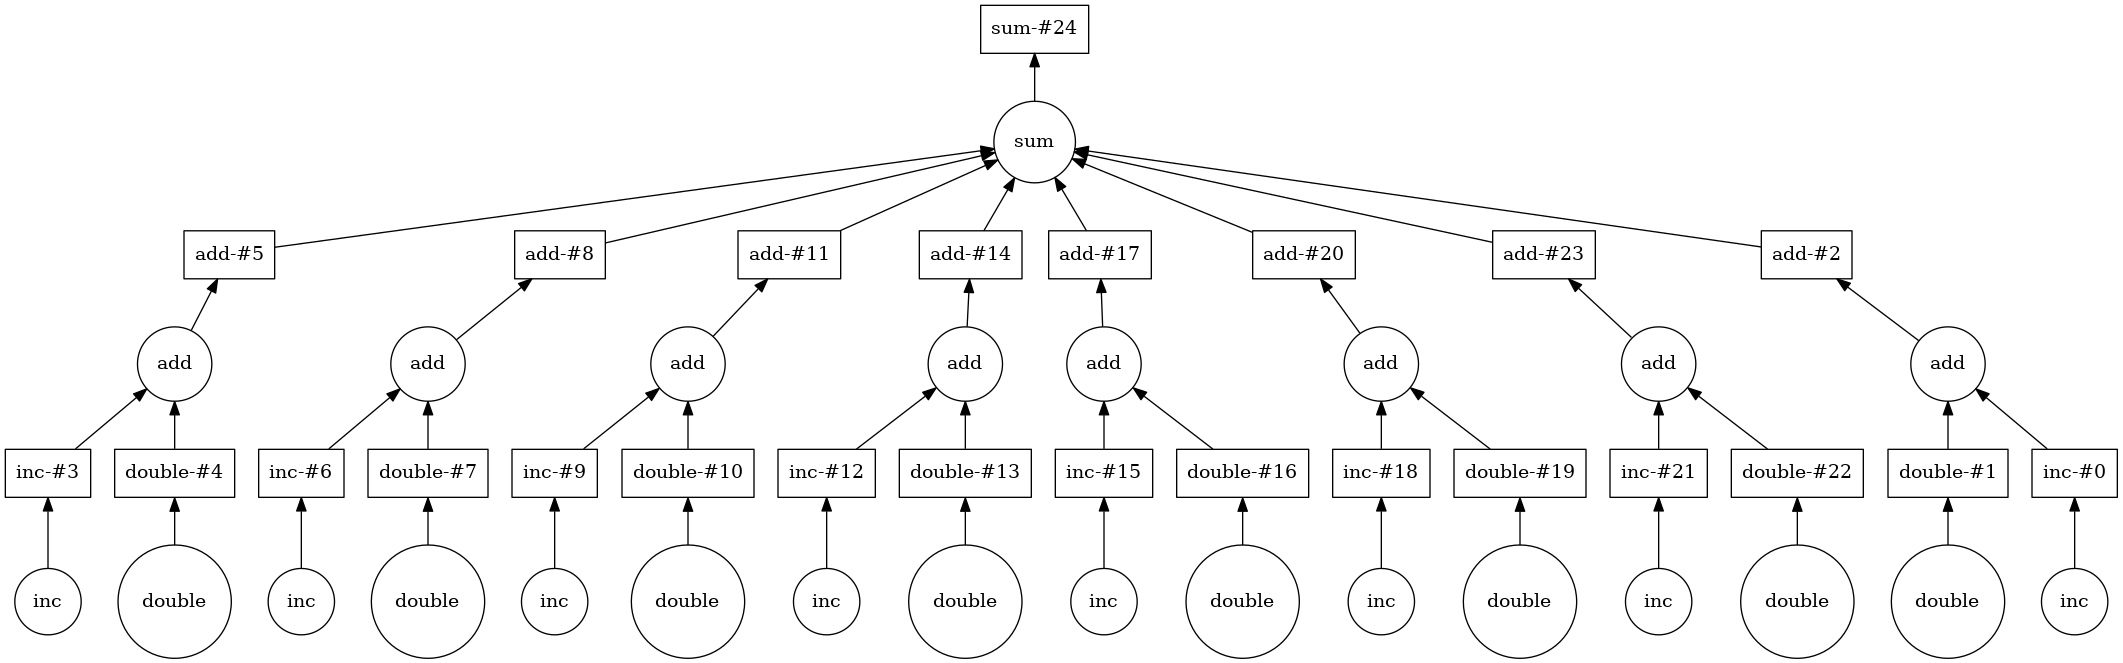

In [58]:
total.visualize()

In [59]:
%time total.compute()

CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 7.19 s


96

# What about our Dataframe?

In [60]:
import dask.dataframe as dd

In [88]:
%%time
df = dd.read_csv('s3://dask-data/nyc-taxi/2015/yellow_tripdata_2015-0*.csv',
                 parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'],
                storage_options={'anon': True})

CPU times: user 572 ms, sys: 28 ms, total: 600 ms
Wall time: 4.31 s


In [89]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


In [90]:
%%time
mean_trip_distance = df['trip_distance'].mean()

CPU times: user 24 ms, sys: 4 ms, total: 28 ms
Wall time: 25.9 ms


In [91]:
%%time
mean_trip_distance.compute()

CPU times: user 2.72 s, sys: 328 ms, total: 3.05 s
Wall time: 18min 54s


13.525389118496381

# Clustering with Dask

In Dask you have **Scheduler** and **Worker**

This has been run on 3 machines with 8GB and 2 cores for each

In [92]:
from dask.distributed import Client, progress

In [93]:
# I am connetting to a scheduler
client = Client("217.182.84.168:8786")

In [94]:
df = dd.read_csv('s3://dask-data/nyc-taxi/2015/yellow_tripdata_2015-0*.csv',
                 parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'],
                storage_options={'anon': True})

In [95]:
%%time
df = client.persist(df)  # spread around all of your workers

CPU times: user 520 ms, sys: 0 ns, total: 520 ms
Wall time: 522 ms


In [85]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


In [97]:
%%time
mean_trip_distance = df['trip_distance'].mean()

CPU times: user 12 ms, sys: 4 ms, total: 16 ms
Wall time: 14.6 ms


In [100]:
%%time
mean_trip_distance.compute()

CPU times: user 308 ms, sys: 24 ms, total: 332 ms
Wall time: 1min 3s


13.525389118496381

In [101]:
%%time
fare_amount = df['fare_amount'].mean()

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 9.48 ms


In [ ]:
%%time
fare_amount.compute()

### Note: Dask implements a small part of the Pandas API

# Thanks!

# Conclusion

* Dask in cool but a little bit still `buggy`
* You can avoid JVM
* **Pandas and Scikit-learn are not aware of Dask**, but you can use them together
* Although parallel machine learning is not trivial and easy to do properly
* Avoid CSVs and start using Parquet

I had to fight to use the cluster with local files, at the end I had to switch to S3

For more info check dask website and the articles from http://matthewrocklin.com/blog/